# Exercise session 7: Analysis of high-dimensional data

In this notebook you will be presented with:
1. Geometric view of data and two types of dimensionality reduction methods
2. Context-dependent models: Choose the right level of description and the right method to distinguish between different implementations of the same function
3. Analyzing Representations in Deep Networks (Alexnet) (in a separate notebook)

In [1]:
# Create a directory to store the files in utils_ex7/data_ctx
!mkdir utils_ex7
!mkdir -p utils_ex7/data_ctx

!wget -P utils_ex7/ https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex7/geometry_utils.py
!wget -P utils_ex7/ https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex7/ctx_dependent_utils.py
!wget -P utils_ex7/ https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex7/get_ctx_data_utils.py
!wget -P utils_ex7/ https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex7/task.png
!wget -P utils_ex7/ https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex7/models_v2.png

from utils_ex7.ctx_dependent_utils import *
from utils_ex7.geometry_utils import *
from utils_ex7.get_ctx_data_utils import *

get_ctx_data()

--2025-01-01 13:26:42--  https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex7/geometry_utils.py
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ManteLab/Iton_notebooks_public/refs/heads/main/utils_ex7/geometry_utils.py [following]
--2025-01-01 13:26:42--  https://raw.githubusercontent.com/ManteLab/Iton_notebooks_public/refs/heads/main/utils_ex7/geometry_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9649 (9.4K) [text/plain]
Saving to: ‘utils_ex7/geometry_utils.py’

geometry_utils.py   100%[===================>]   9.42K  --.-KB/s    in 0s      

2025-01-01 13:

## Part I. Geometric view of data

Imagine we have samples that represent the activity (firing rates) of two recorded neurons on different trials. Each point in the scatter plot is the activity on a trial. Trials can be grouped by the motor ouput of the subject (blue for choice 1 and red for choice 2).


The mean of each choice-class is fixed, but you can change the covariance matrix within each choice-class by adjusting the slider “Corr Coeff“.

You should get a feel for how changing the correlation coefficient affects the geometry of the simulated data.

In [2]:
iplot_data()

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Corr Coeff', max=1.0, min=-…

**Assignment 1** What effect do negative correlation coefficient values have?
<details>
<summary>Answer</summary>
Negative and positive coefficient values result in ellipse-like structure of the data. A negative correlation coefficient implies a negative relationship, i.e. positive values along X1 correspond to negative values along X2.
</details>

**Assignment 2** What correlation coefficient results in a circular data cloud?
<details>
<summary>Answer</summary>
When the correlation coefficient is 0 it means the variables are uncorrelated. This results in a circular data cloud.
</details>

As you saw in Lecture 6 and 7, as we go deeper into the brain, responses of single neurons appear to represent several different signals at once. Therefore, it is more common nowadays to analyse the responses of the population as a whole. The activity of the recorded units is then represented in a high-dimensional space, where the number of neurons determines the dimensionality (if you record from 200 units then the dimensionality is 200).

To study how the population as a whole encodes task variables (motor output, sensory input and other inferred behavioral variables like the subject's confidence for example) we represent population responses as trajectories in neural state space.  Each point
in state space corresponds to a unique pattern of neural activations across the population. We modified the dataset above such that each unit not only encodes the motor ouput (choice 1 or choice 2) but also encodes the strength of the sensory input (color coded by color intensity - dark red/blue for strong input and light red/blue for weak input).

### Finding new bases

When we analyze high-dimensional neural data we focus on a low-dimensional subspace. In this part of the tutorial we will introduce two dimensionality reduction methods.
1. Principal Component Analysis is a technique used to reduce the dimensionality of data by transforming it into a new coordinate system, where the largest variance by any projection of the data lies on the first axis (called the first principal component), the second largest variance on the second axis, and so on.
2. Targeted dimensionality reduction focuses on reducing the dimensionality in a way that aligns with specific features or variables of interest, rather than maximizing overall variance as in PCA.

In the first part of this notebook we will explore how multivariate data can be represented in different bases. For PCA, the new basis is the one spanned by the Principal Components explaining the highest portion of variance in descending order.

For TDR, we define an orthonormal basis by finding task-relevant axes (as opposed to high-variance axes). We begin by describing the response $r_{i,t}(k)$ of unit $i$ at time $t$ on trial $k$ as a linear combination of several task variables:


\begin{align*}
  r_{i,t}(k) = \beta_{i,t}(1) \mathrm{choice}(k) + \beta_{i,t}(2) \mathrm{input_{strength}}(k)\\
\end{align*}

Make sure you understand the equation above. Why does $\mathrm{choice}(k)$ depend on $k$ but not on $t$?

The regression coefficients describe how much the trial-by-trial firing rate of unit $i$ depends on the corresponding task variable $v=1,2$. We use these regression coefficients to identify dimensions in state space containing task related variance.

For each task variable v = 1,2 we first build a set of coefficient vectors $\vec{\beta}_{v,t}$ whose entries $\beta_{v,t}(i)$ correspond to the regression coefficient for task variable $v$, time $t$ and unit $i$. Each vector $\vec{\beta}_{v,t}$ corresponds to a direction in state space that accounts for variance in the population response at time $t$, due to variation in task variable $v$.

Finally we obtain orthogonal axes of choice and input strength by orthogonalizing the regression vectors with QR-decomposition. The resulting axes span the same 'regression subspace' as the original regression vectors, but crucially each explain distinct portions of the variance in the responses.


### Projecting onto the new basis

Lastly, we will express our data in the new basis that we have just found, by projecting the data into our new basis using matrix multiplication: $\mathbf{Y} = \mathbf{X}\mathbf{W}$, where $\mathbf{Y}$ is the data in the new basis, $\mathbf{W}$ is the basis (either the principal components in PCA or $[\vec{\beta}_{\mathrm{choice}}, \vec{\beta}_{\mathrm{input}}]$ in TDR) and $\mathbf{X}$ is the data in the original basis (the full neural space for example). For one time point, the dimensionality of $\mathbf{X}$ is $N_{units} \times 1 $, the dimensionality of $\mathbf{W}$ is $N_{units} \times N_{coeffs}$ and the dimensionality of $\mathbf{Y}$ is $N_{coeffs} \times 1$, where $N_{units}$ is the number of units and $N_{coeffs}$ is the number of axes (in PCA the number of principal components we keep and in TDR the number of task variables).

In this part of the tutorial you should understand how the identified principal components relate to the geometry of the data. In the second part, you will see how to choose the number of principal components to further analyze by looking at their variance explained.

**Assignment 3** Which method is better when corr-coeff is negative? What about when corr-coeff is positive?
<details>
<summary>Answer</summary>
When the correlation coefficient is negative, PCA1 axis does not separate choice-1 trials from choice-2 trials, but TDR-choice does. When the correlation coefficient is positive, TDR-choice axis corresponds to PCA1.
</details>

**Assignment 4** What is the effect of orthogonalization order (input strength first vs. choice first) on the identified task relevant subspace?
<details>
<summary>Answer</summary>
In this data, choice and input strength are correlated, i.e. there is a small angle between TDR-choice (the axis that best separates choice-1 points from choice-2 points) and TDR-input (the axis that best separate dark-intensity points from low-intensity points).

When we orthogonalize in the order: [TDR-choice, TDR-input], projections along TDR-choice will capture well the difference between choice-1 points vs. choice-2 points, but TDR-input will no represent well the input-strength - points with high input strength (dark intensity) and points with low input strength (light intensity) are mapped onto the same projection values (4th plot).

When we orthogonalize in the order: [TDR-input,TDR-choice], projections along TDR-input will capture well the difference between high and low inputs strength (high input strength are mapped to positive projection values and low input strength will be mapped to negative projection values), but TDR-choice will not represent choice.
</details>

In [3]:
iplot_data_2classes()

We display the effects of PC1 and TDR-choice axis by plotting a histogram of projections for choice 1 and a histogram of projections for choice 2 to highlight how well each method separates the two choices (a <ins>classification problem</ins>). For TDR-input we use a scatter plot to highlight whether the linear increase of input strength is preserved across the identified axis (a <ins>regression problem</ins>).

# Part II. Context-dependent models

In the second part of this notebook we will give you 4 datasets. What these datasets have in common is that they all achieve the same function, but through different implementations. Your task will be to distinguish the different implementations by choosing the right level of description: single-unit or population-level response and by  applying the methods introduced in the previous section: PCA, TDR, order of orthogonalization.

<ins>The behavioral task:</ins> All 4 datasets implement selective integration. On each trial, two inputs are presented, a motion input and a color input, of different strengths. Depending on the context, motion context or color context, the subject needs to integration the relevant input (motion input in motion context and color input in color context) and ignore the irrelevant input (motion input in color context and color input in motion context).

The motion input has two directions. On correct trials, motion to the right is associated with a choice to the right (choice 1) and motion to the left is associated with a choice to the left (choice 2). Similarly, the color input has two directions. On correct trials, red is associated with a choice to the right (choice 1) and green is associated with a choice to the left (choice 2). We will only analyze correct trials. Each input has 3 different strengths (weak 5, medium 15, strong 50) for each choice (-50, -15, -5 for choice 2 and 50, 15, 5 for choice 1).

In the figure below you can see the task might look like (a) and the stimulus set (b).

**Assignment 5** How can you interpret the psychophysical curves in c-f? Why are c & d different? Why are c & f similar?
<details>
<summary>Answer</summary>
The psychophysical curves inform us whether the subject is actually solving the task. c & f show how the relevant input affects the choices. For e.g. in c: 100% chooses Right when motion is +d3, i.e. to Right. d & e show how the irrelevant input affects the choices.

Consider the two cases below. In the motion context, the correct choice is to choose Left, while in the color context is to choose Green (Left for trial 1 and Right for trial 2). Plot d shows how the color coherency affects choosing green or red in the motion context. If in the motion context, the subject is choosing Left on both trials, the probability of choosing Green, given a green stimulus is 0.5 (1/2). This shows that color does not affect choice. If, however, the subject would pay attention to color and consequently choose Green on trial 1 (left) and Green on trial 2 (right), the probability of choosing Green, given a green stimulus would be 1 (2/2). This shows that color affects choice.

</details>


In [5]:
show_example_trials()

FileNotFoundError: [Errno 2] No such file or directory: '/content/utils_ex7/example_trials.png'

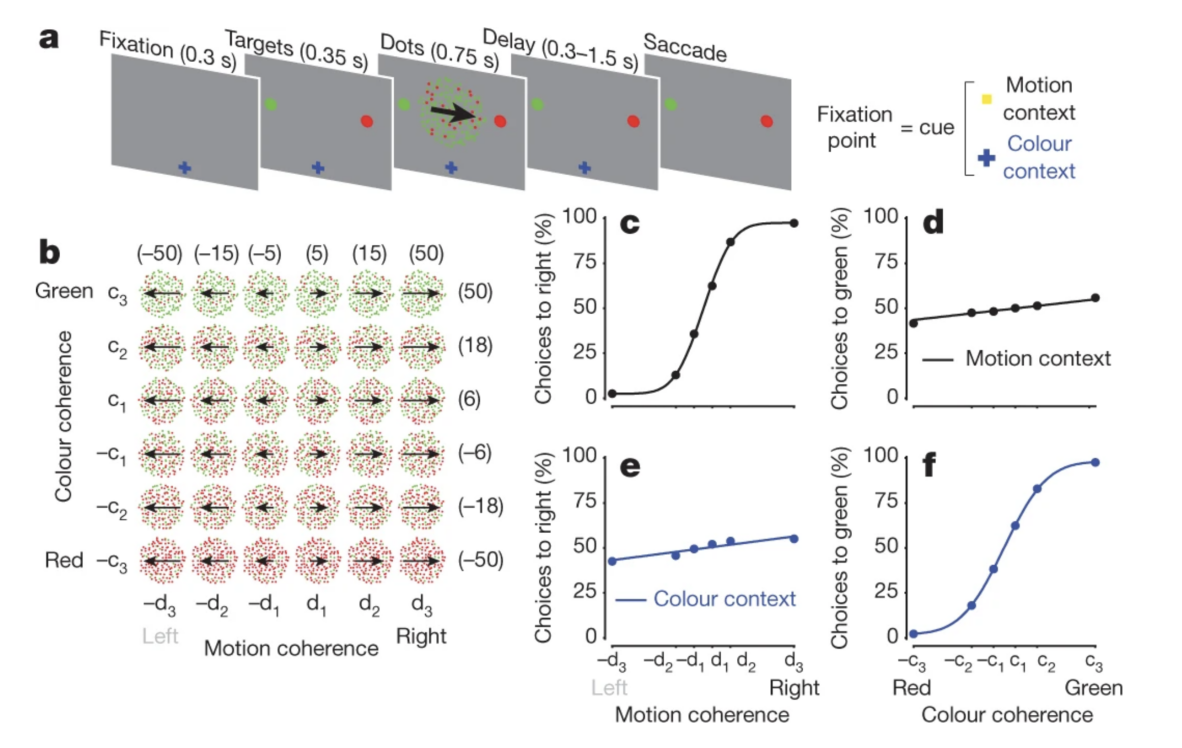

In [6]:
show_task()

The 4 datasets differ with respect to the relative directions and context dependence of the choice axis (red lines) and the inputs (black and blue lines).

<ins>Model 1: Early selection.</ins> When relevant, the motion input pushes the population response along the choice axis. When irrelevant, the motion input is filtered out before and thus exerts not effect on choice. Motion input is aligned with choice in motion context (top row, left panel) and color input is aligned with choice in color context (bottom row, right panel). Color input is not present in motion context (top row, right panel - no blue line) and motion input is not present in color context (bottom row, left panel - no black line).

<ins>Model 2: Context-dependent input direction.</ins> Motion input direction varies between contexts, whereas the choice axis is stable (red line is consistent across both contexts - top and bottom row). Inputs are selected based on the basis of their projection onto the choice axis. Motion input is aligned with choice axis in motion context (top row, left panel) and color input is aligned with choice axis in color context (bottom row, right panel). Motion input is orthogonal to choice axis in color context (bottom row, left panel) and color input is orthogonal to choice axis in motion context (top row, right panel). Motion axis (black line) is different between motion context and color context (left panel, top and bottom row) and similarly, color axis (blue line) is different between the two contexts. In this mechanism, the output direction is abstract.

<ins>Model 3: Context-dependent output direction.</ins> Choice axis varies between contexts, whereas motion input direction is stable (blue/black lines have same direction in the two context, top and bottom row). Inputs are selected based on the basis of their projection onto the choice axis. Motion input is aligned with choice axis in motion context (top row, left panel) and color input is aligned with choice axis in color context (bottom row, right panel). Choice axis is different between the two contexts (in motion context the red axis is horizontal, top row and in color context the red axis is vertical, bottom row). In this mechanism, the input direction is abstract.

<ins>Model 4: Context-dependent selective integration.</ins> All axes (motion, color and choice) are stable across contexts. The same input (motion) leads to integration in motion context, but is ignored in the color context. This is a new mechanism that will be presented in Lecture 9. For now it is important to understand that the input axes are coupled to the choice axes in a context-dependent manner and that this is the only mechanism where all three axes are abstract.

The concept of Abstraction was introduced on Slide 38-42 of Lecture 7 (Possible Geometries).

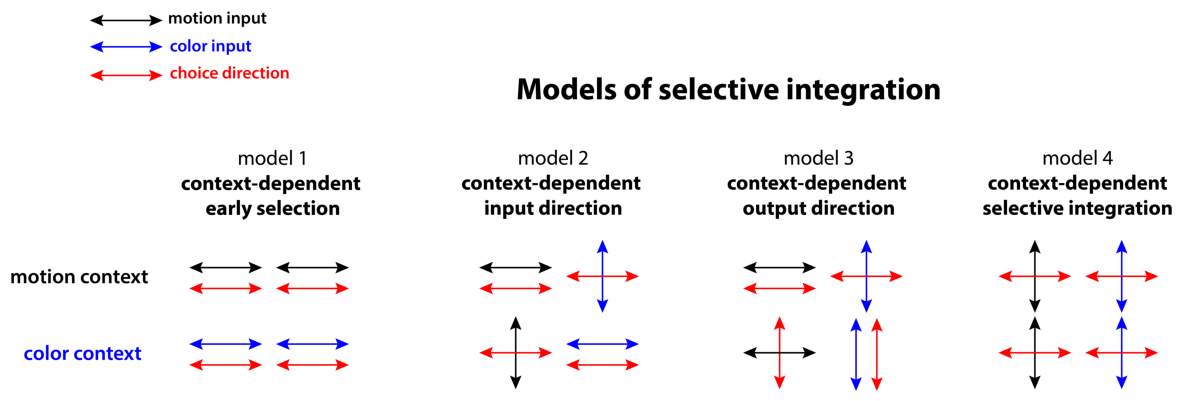

In [7]:
show_models_geometry()

Load the datasets:

In [8]:
# Run without changing
model_a = load_context_dependent_models('model_a')
model_b = load_context_dependent_models('model_b')
model_c = load_context_dependent_models('model_c')
model_d = load_context_dependent_models('model_d')

## Single unit analysis

<ins>The neural data:</ins> You have the activity of 500 units recording during input presentation. For the rest of the notebook we will look at condition-averages, where we group trials according to certain conditions and observe the averaged activity.

Below you can visualize condition-averages. Each time you run the cell below, you will see the condition-averaged activity of 6 randomly selected neurons.
- In the first row, trials are sorted by choice (continuous line for choice 1 vs dashed line for choice 2 across all trials).
- In the second row, trials are sorted by the strength of motion input (weak in light grey to strong in black) and choice (same continuous vs dashed line as above) and only trials for motion context are considered.
- In the third row, the same split of data but now for color input and color context.
- In the fourth row, trials are sorted by context (motion in black and color in blue) and choice (same continuous vs. dashed line) for all trials.

**Assignment 6** Plot condition averaged (PSTHs) from all four models. Can you identify some PSTHs that are specific to a model? What about PSTHs that are common across models?

<details>
<summary>Answer</summary>
For all models you can find neurons whose behavior is easy to understand, for e.g. neurons that encode choice (first row, continuous red line different than dashed red line), neurons that encode motion input in motion context (second row, the 6 lines are nicely ordered from dark blue, medium blue, light blue for choice 1 continuous line to light blue, medium blue, dark blue for choice 2 dashed line). But for most neurons it is very difficult to understand what they are representing.

To extract from the neurons only information related to the task, and have a way to summarize it for all neurons, we will use an encoding model (TDR).

</details>

**** Sort by choice (all trials) ****


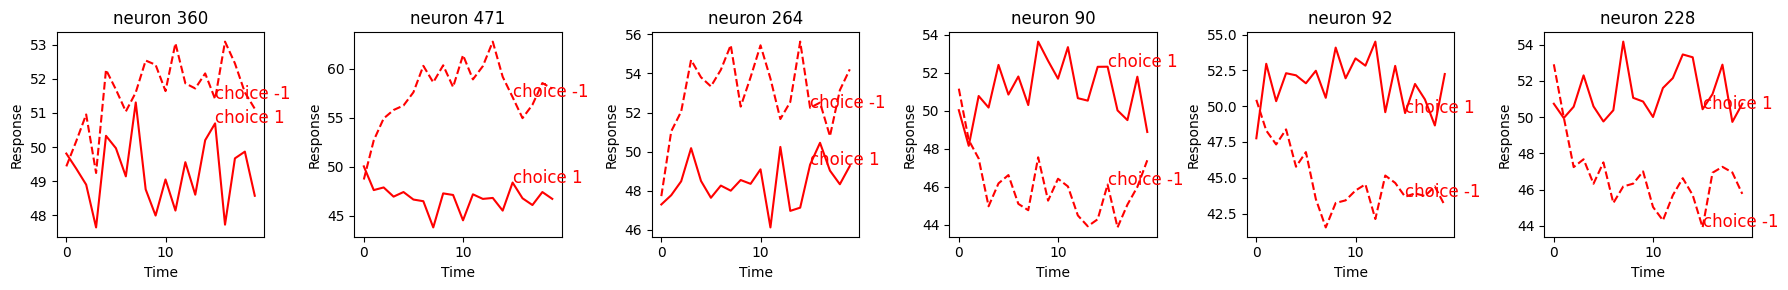

**** Sort by motion and choice (motion context) ****


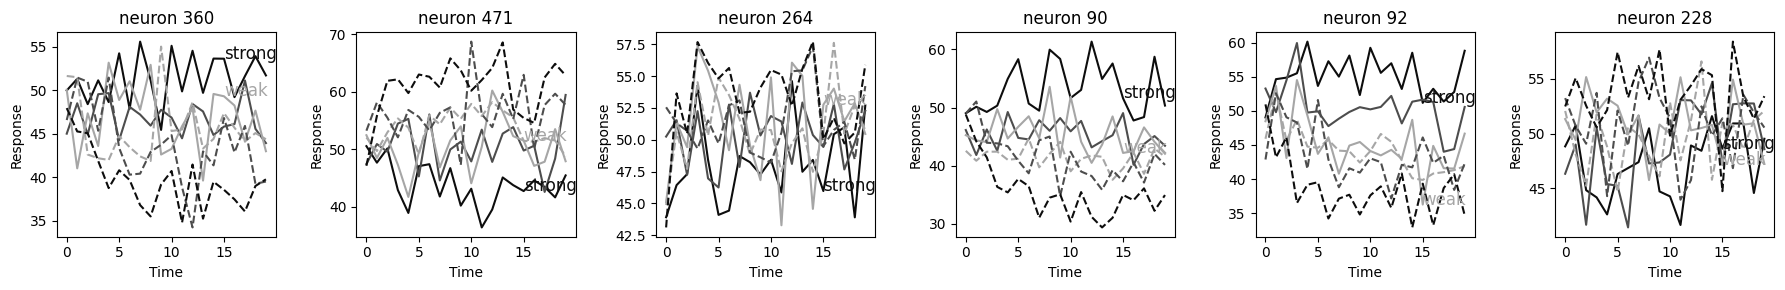

**** Sort by color and choice (color context) ****


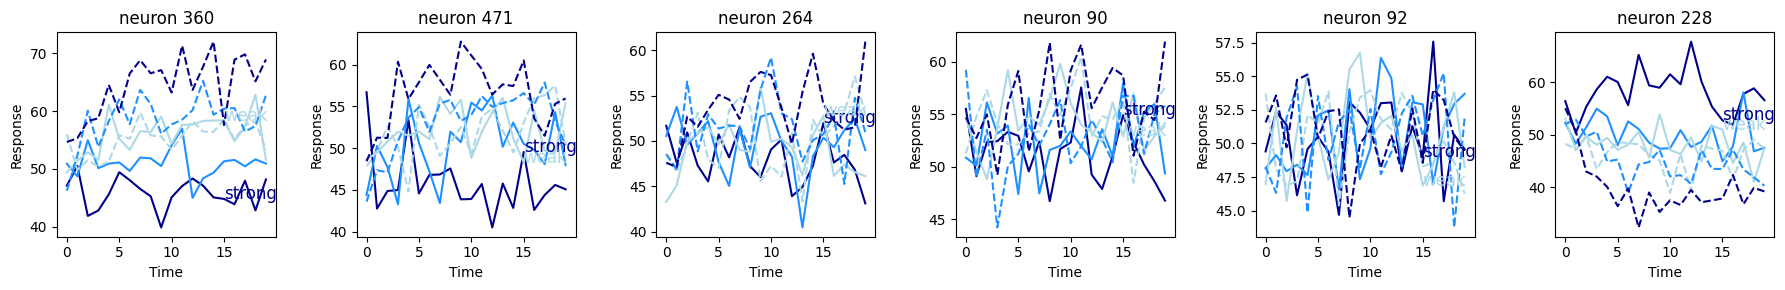

**** Sort by context and choice (all trials) ****


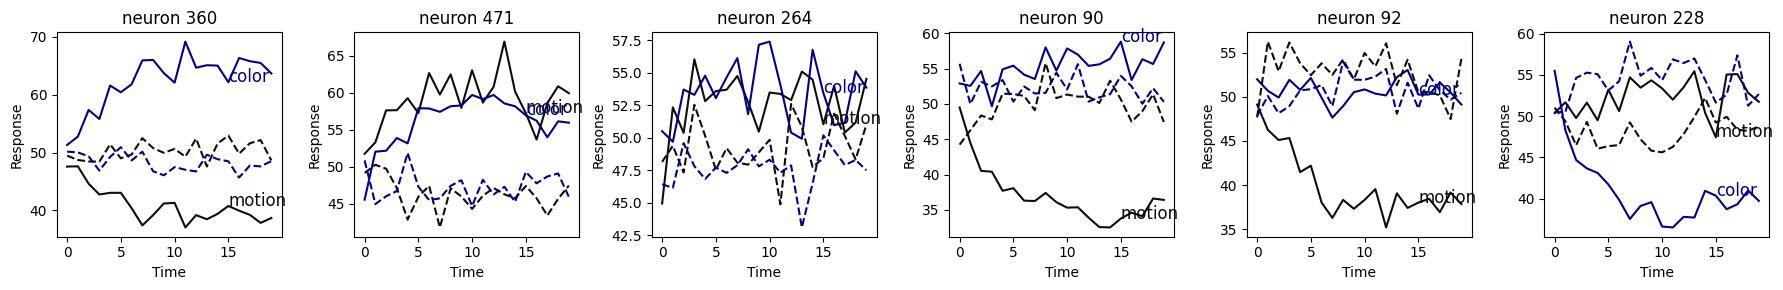

In [9]:
plot_psths(model_a)

### Encoding models

How to determine if a neuron is selective to a behavioral variable? This regression equation was introduced on Slide 57 (not numbered?) of Lecture 7. The intercept is (5) as opposed to (1) - what is on the Lecture Slides.

We use multi-variable linear regression to determine how various task variables affect the responses of each unit.
\begin{align*}
  r_{i,t}(k) = \beta_{i,t}(1) \mathrm{choice}(k) + \beta_{i,t}(2) \mathrm{motion_{strength}}(k) + \beta_{i,t}(3) \mathrm{color_{strength}}(k) + \beta_{i,t}(4) \mathrm{context}(k) + \beta_{i,t}(5)\\
\end{align*}

In the top row of the figure below, we plot the regression coefficients estimated with the equation above against each other. Each point is a neuron. Notably, we estimate these regression coefficients from all trials. Moreover, as seen in the equation above, we estimate a set of regression coefficients at each time, but in the plots below we will only focus on one time point. For each regression coefficient we selected the time point where the absolute value was the highest.

In the bottom row, we estimate the regression coefficients for each context separately, i.e. we will estimate $\beta_{i,t}(1)$ for choice, $\beta_{i,t}(2)$ for motion input and $\beta_{i,t}(3)$ for color input separately for motion context, resulting in choice(motion), motion(motion) and color(motion). Similary, we estimate them for the color context and obtain choice(color), motion(color) and color(color).

**Assignment 7** What means a positive $\beta_{i,t}$? What about a negative $\beta_{i,t}$?
<details>
<summary>Answer</summary>
A positive β<sub>i,t</sub> shows a positive relation, while a negative β<sub>i,t</sub> shows a negative relation. See Slide 21 of Exercise 7 PDF Slides.

</details>

**Assignment 8** What is the difference between $\beta_{i,t}$ = 0.5 and $\beta_{i,t}$ = 4?
<details>
<summary>Answer</summary>
β<sub>i,t</sub> = 4 would indicate a stronger relation between the firing rate and the task variable than a β<sub>i,t</sub> = 0.5.
</details>

**Assignment 9** What does it mean when $\beta_{i,t}(1)$ (for choice) vs $\beta_{i,t}(2)$ (for motion) is a circular data cloud? What about when it is an ellipse?

<details>
<summary>Answer</summary>
When β<sub>i,t</sub>(1) (for choice) vs β<sub>i,t</sub>(2) (for motion) are a circular data cloud, it means that the two regression coefficients are uncorrelated. A neuron that is encoding (representing) choice does not necessarily encode motion. Alternatively, if the points are in an ellipse, the regression coefficients are correlated, and thus, a neuron that represents choice also represents motion.
</details>


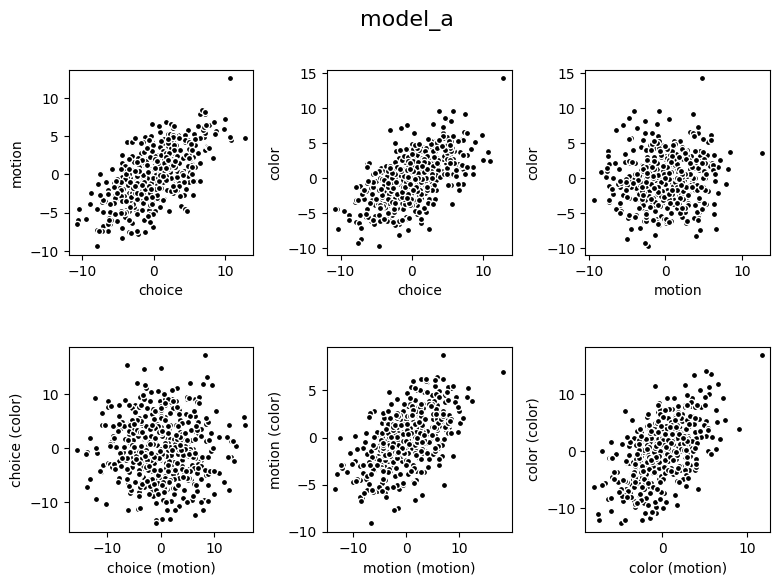

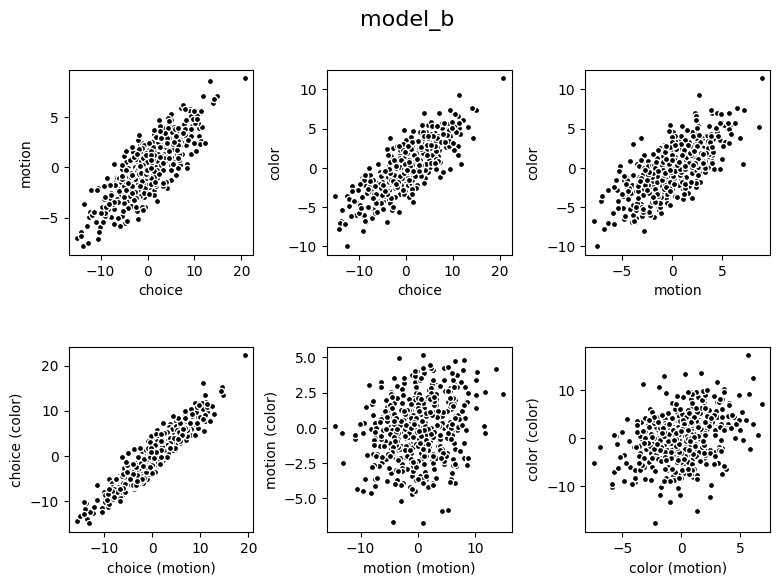

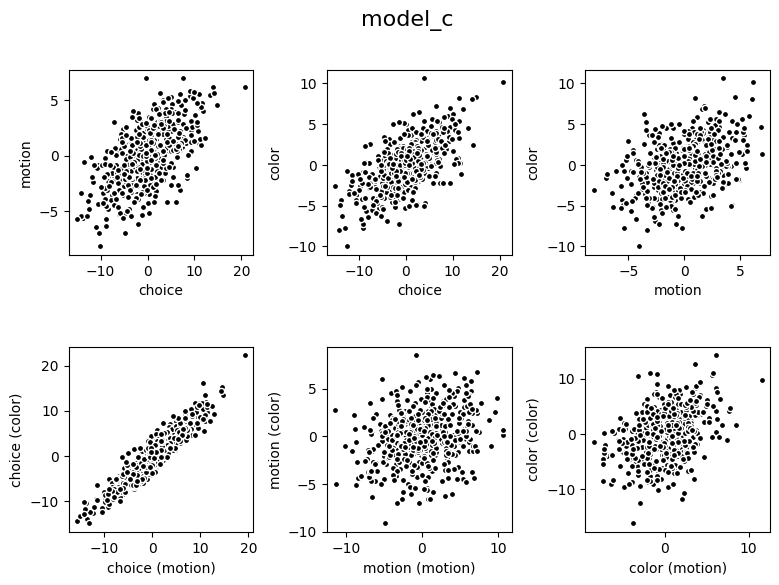

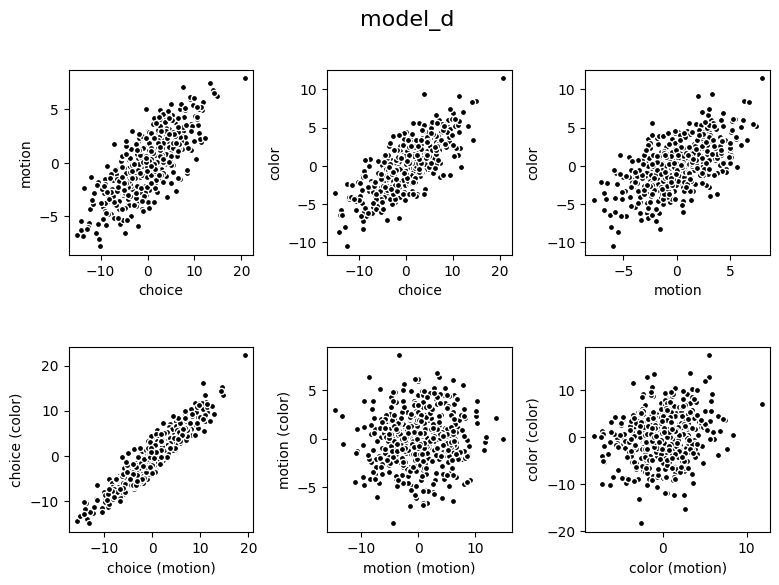

In [13]:
plot_tunings(model_a)
plot_tunings(model_b)
plot_tunings(model_c)
plot_tunings(model_d)

**Assignment 10** Do any of the models have $\beta_{i,t}(1)$ (for choice in color context) vs $\beta_{i,t}(1)$ (for choice in motion context) as a circular data cloud? What does this mean for the choice axis?
<details>
<summary>Answer</summary>
In model_a a neuron might encode choice in motion context, but not in color context. At the level of the population, this means that the choice vector in color context is orthogonal to the choice vector in the motion context.
</details>


**Assignment 11** Summarizing the Single-unit analysis part. Can you distinguish between the models by looking at the single unit properties? If not completely, can you at least rule out some associations, for e.g. make statements of the type 'model_a is definitely model 1'?

<details>
<summary>Answer</summary>
We cannot distinguish the different implementations from the scatter plots. The only thing we can observe is that model_a has a context-dependent choice vector (See Assignment 10) and only model 3 has this geometry.
</details>

## Population-level analysis

Next we will study the population as a whole. We will reduce the dimensionality of the dataset from 500 dimensions to 4 dimensions with PCA and 3 dimensions with TDR. Both these two methods were introduced in the first part of the notebook.

In TDR we can investigate whether the chosen task variables are represented in the neural population by computing a time-dependent Frobenius norm.

**Assignment 12** Which task variable has the highest norm?
<details>
<summary>Answer</summary>
The choice-vector has the highest norm. This means that neurons represent the choice variable most reliably (more reliable than motion, color and context).
</details>

**Assignment 13** Which do some task variables have a constant norm and some a time-dependent norm?
<details>
<summary>Answer</summary>
The choice-vector represents evidence accumulation. Here is where the subject is deciding, making up their mind. Therefore we expect the choice signal to have a ramp up time-course. As the subject is deciding, the choice is better represented late in the trial (t=20) than early in the trial (t=5). The context is a variable that is always known (the subject always knows in which context he is), therefore we expect this signal to be constant, i.e. similarly represented early and late in the trial. The time-course of the motion and color input vectors has a step-like shape - stimulus is turned on -> norm goes up, stimulus is turned off -> norm goes down.

For model_a the context vector has a similar time-course as the choice vector. As we saw in the previous section, model_a is model 3, the only model where choice axis is different between the two contexts. Therefore, the context variable and the choice variable are correlated. In this case, the context vector (the context beta coefficients) explain both the contribution of choice (gradual increase) and of context (constant) to the neuron's firing rate.

</details>

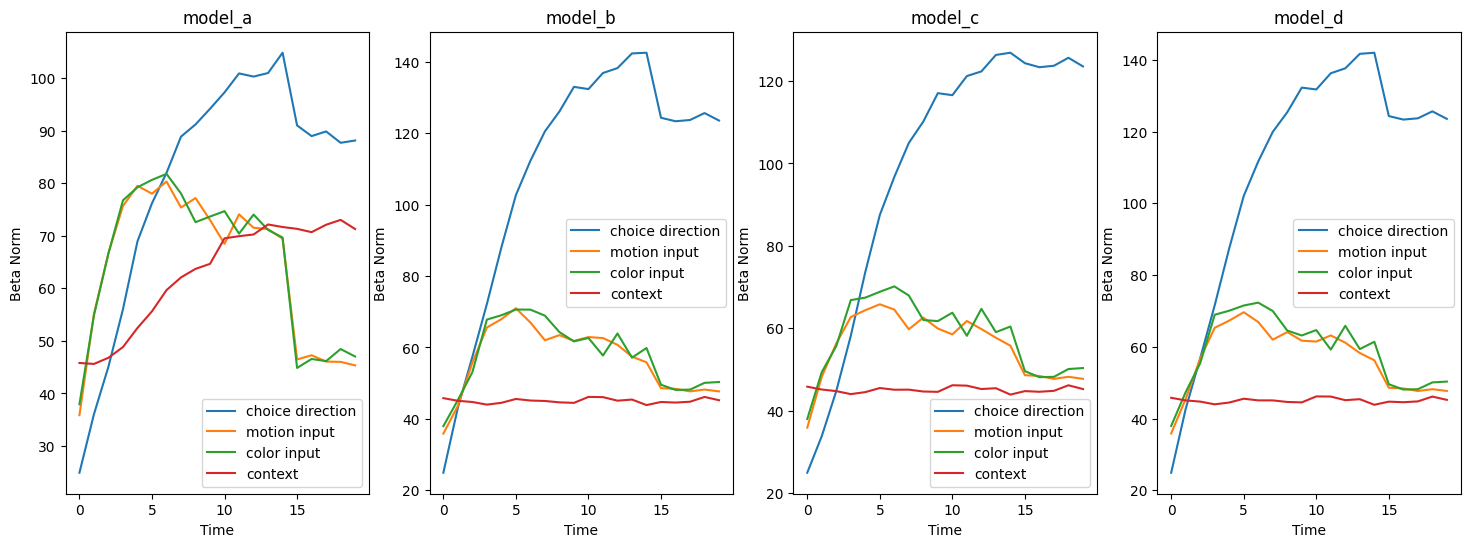

In [14]:
# Run without changing

plot_beta_norm(model_a, model_b, model_c, model_d)

In PCA we can look at variance explained by each PC. The y-axis on the left shows the cumulative variance explained (blue - it increases and it approaches 100) and the y-axis on the right shows the log-scale of variance explained (green - it decreases and when plotted on a log-scale it shows this sharp transition).

**Assignment 14** Inspecting the figure below, how many principal components would you choose for further analyses?
<details>
<summary>Answer</summary>
The sharp change indicates the most important PCs that explain most variance. It is called the elbow effect. We will focus the rest of the analyses on the first 4 PCs because they explain >80% of the variance.
</details>

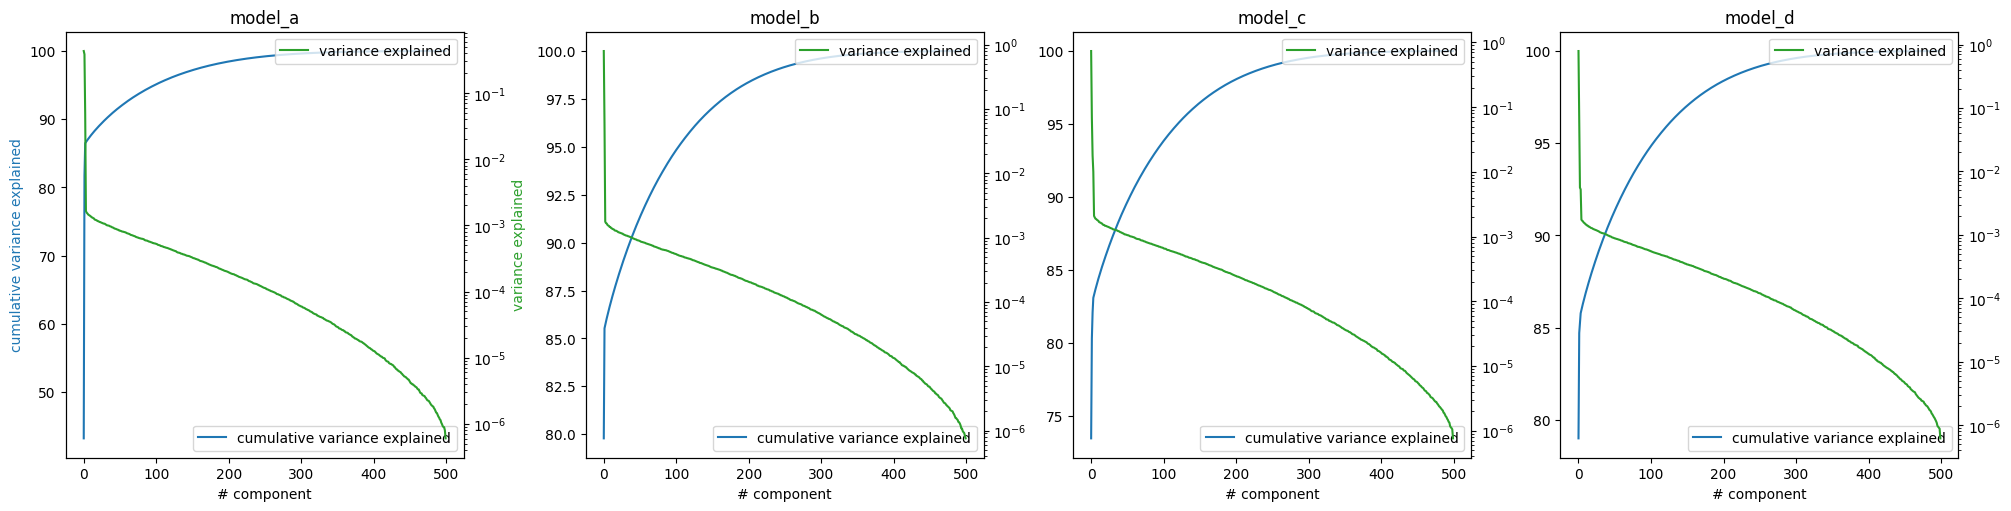

In [15]:
# Run without changing

plot_pca_var_explained(model_a, model_b, model_c, model_d)

### 1-d Projections

Relevant input: motion input in motion context or color input in color context
- 6 conditions (-50, -15, -5 for choice 2 and +50, +15, +5 for choice 1)

Irrelevant input: motion input in color context or color input in motion context
- 12 conditions (-50, -15, -5, 5, 15, 50 for choice 1 and -50, -15, -5, 5, 15, 50 for choice 2)


Filled circles represent when the input (relevant or irrelevant) points towards choice 1 and open circles when the input points towards choice 2. The color-intensity represents the input strength (black, grey, light grey for strong, medium, weak motion input respectively and dark blue, medium blue, light blue for strong, medium, weak color input).



Below you can use PCA or TDR to visualize 1-d trajectories. The y-axis illustrates the projection value and the x-axis illustrates time.

For PCA you can run: plot_projections_1d(model_a, 'pca') and select the model: model_a, model_b, model_c, model_d

For TDR you can run: plot_projections_1d(model_a, 'tdr', ['input_motion','input_color', 'choice']). The last argument determines the order of orthogonalization. You can choose between:

['input_motion', 'choice', 'input_color']

['choice', 'input_motion', 'input_color']

['input_motion','input_color', 'choice']



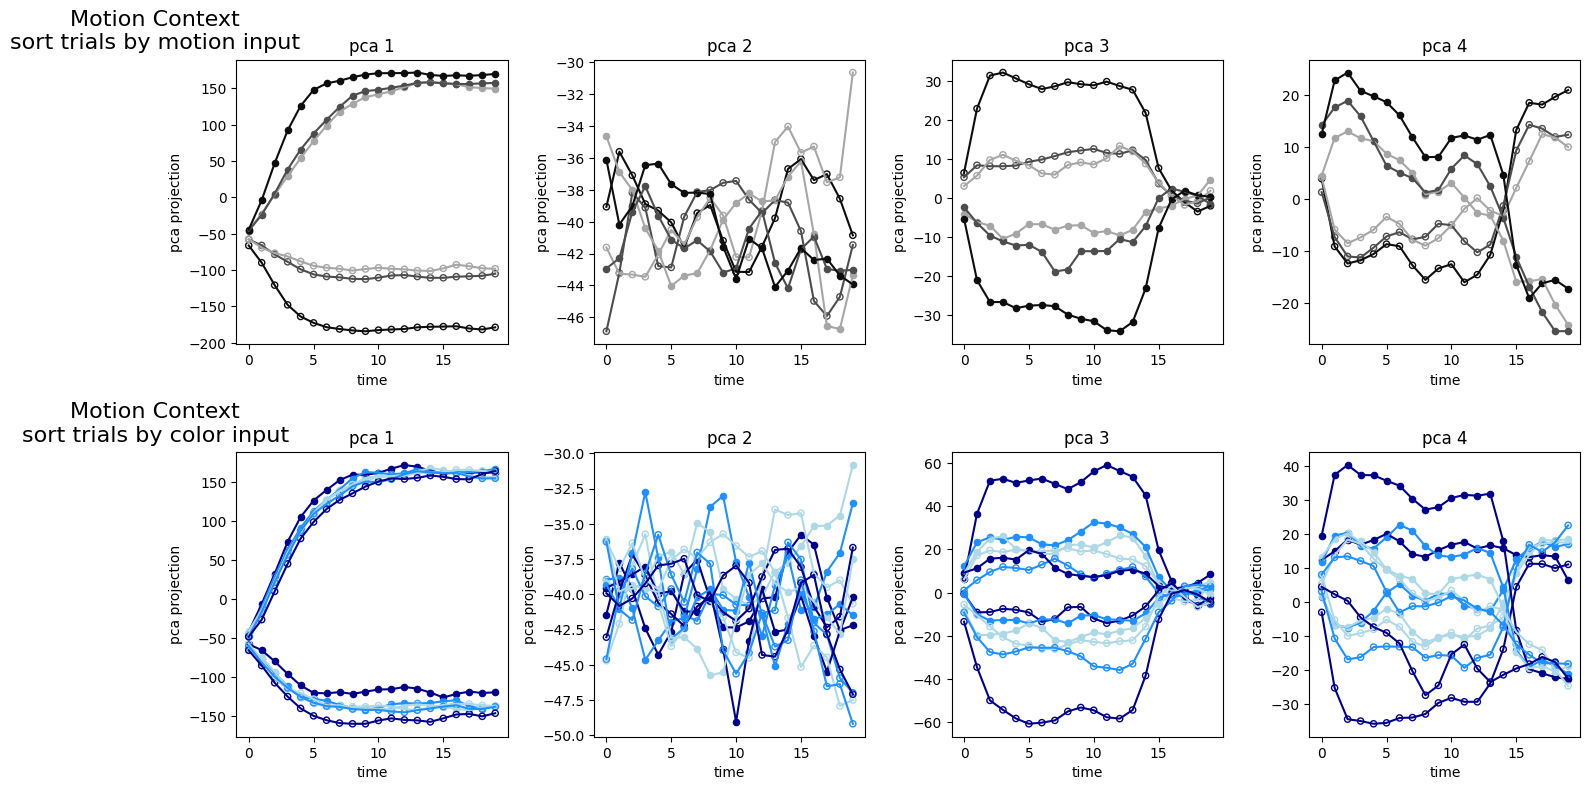

In [17]:
# Here you can select the method (pca or tdr), the context (motion or color) and the order of orthogonalization (relevant only for tdr). We provide example for the different ways to run it below:

#context = 'color'
context = 'motion'

#order_orthogonalization = ['input_motion',  'input_color', 'choice']
#order_orthogonalization = ['input_motion', 'choice', 'input_color']
order_orthogonalization = ['choice', 'input_motion', 'input_color']

plot_projections_1d(model_c, 'pca', [], context)
#plot_projections_1d(model_b, 'tdr', order_orthogonalization, context)


Make sure you understand why in some cases you have 6 lines and in some cases you have 12 lines.

How the order_orthogonalization affects the projections was explained in class (see Slides 36-43 of Exercise Session 7 (Population Representations)).

The correct way of orthogonalizing is: order_orthogonalization = ['choice', 'input_motion', 'input_color']

**Assignment 15** Can you relate the time profile of TDR projections with the Frobenius norm estimated above?
<details>
<summary>Answer</summary>
Yes. Projections along the choice-axis have a gradual increase, starting at an unbiased location (or conditions are centered at 0) and going towards one of the locations -  positive projections for one choice and negative projections for another choice.

Projections along the motion and color-axis have a step-like time-course, mimicking the time-course and the coherency of the input.
</details>

**Assignment 16** Can you relate the strength of PCA projections and the variance explained estimated above?
<details>
<summary>Answer</summary>
Yes. The first principal component explains the most variance and thus the conditions have highest projection values onto this axis. The later principal components explain less variance, and thus the conditions have low projection values on these axes.
</details>

**Assignment 17** Can you identify differences and similarities between PCA and TDR?
<details>
<summary>Answer</summary>
Because choice is the dominant signal in this dataset (see norm of the choice beta coefficient), the choice vector (TDR), which explains variance due to choice, corresponds to PC1, which explains the largest variance across all points (agnostic to which points belong to choice-1 and which points belong to choice-2). So PC1 and the choice-vector (TDR) are similar (when choice-vector is put first in the orthogonalization). The other axes PC2-4 are very different from the remaining TDR axes (motion and color vector).
</details>


## 2-d Projections

Same conditions as for 1-d projections. For 2-d projections we plot time-dependent trajecties of two axes against each other (for e.g. pc1 vs. pc2, or choice vs. motion input). The start of the trajectories is marked by the purple circle in all plots below.


### PCA

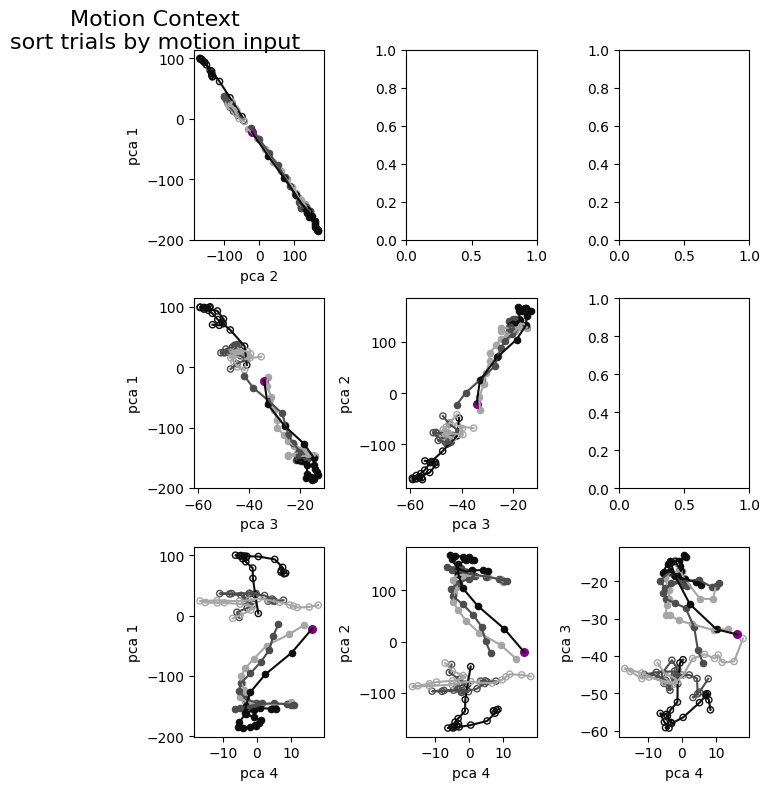

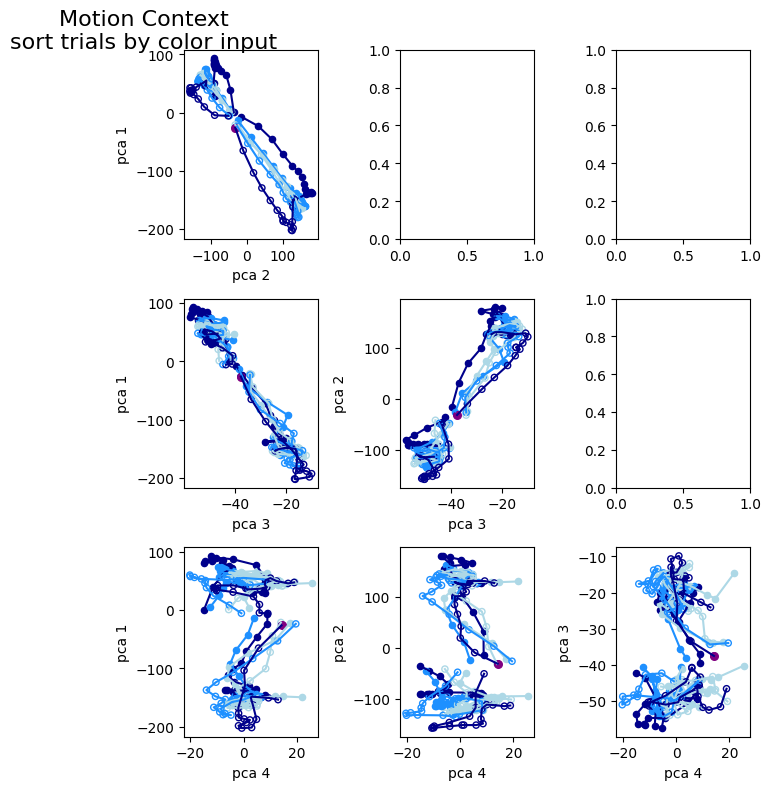

In [18]:
# Here you can select the context.

#context = 'color'
context = 'motion'

plot_projections_2d(model_a, 'pca', [], context)

**Assignment 18** Is there any structure that is visible in 2-d projections but was not apparent in 1-d projections when using PCA?
<details>
<summary>Answer</summary>
Because PCA is not designed to capture variance due to task variables, the projections do not help us understand how the variables are represented. Plotting 2-d projections is not more helpful than 1-d projections.
</details>

### TDR

We will now build 2-d TDR projections like in Lecture 7, Slide 58 and after (not numbered?).

“motion (color)“ refers to motion input axis in color context. So in the figures below, the top row refers to motion context and the bottom row to color context.

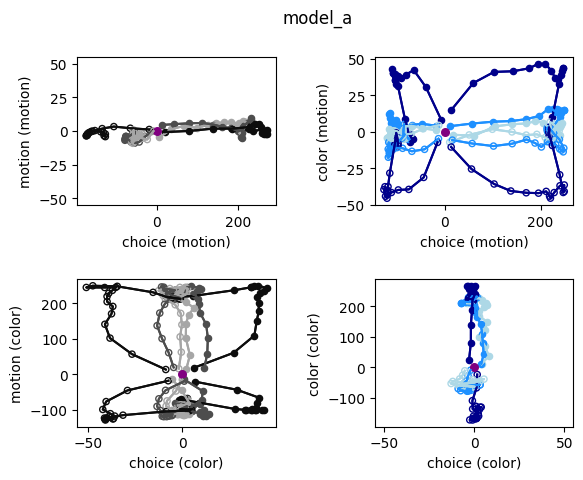

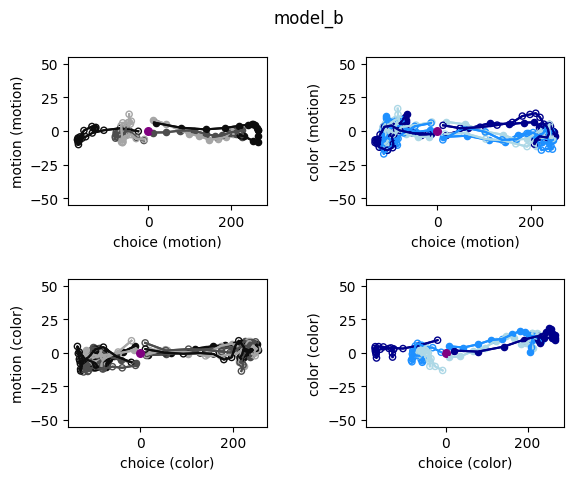

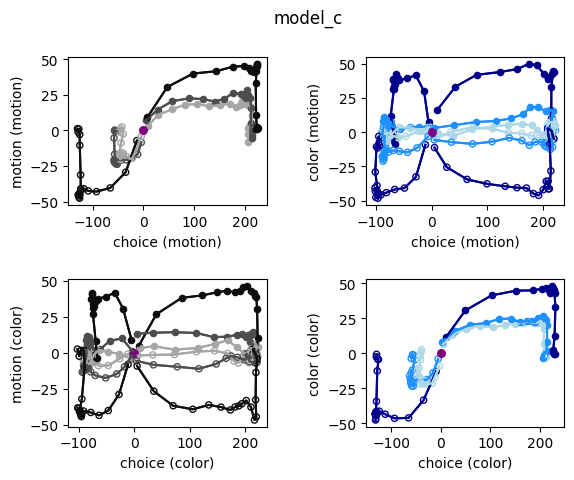

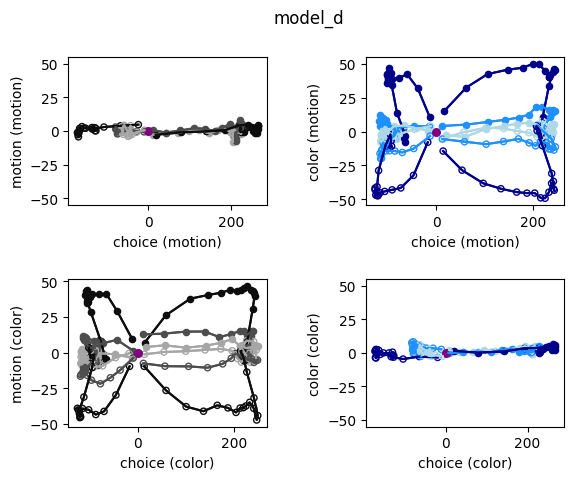

In [19]:
# Here you can select the order of orthogonalization and which model you want to analyze.

#order_orthogonalization = ['input_motion',  'input_color', 'choice']
order_orthogonalization = ['choice', 'input_motion', 'input_color']
#order_orthogonalization = ['input_motion', 'choice', 'input_color']


plot_projections_2d(model_a, 'tdr', order_orthogonalization)
plot_projections_2d(model_b, 'tdr', order_orthogonalization)
plot_projections_2d(model_c, 'tdr', order_orthogonalization)
plot_projections_2d(model_d, 'tdr', order_orthogonalization)


**Assignment 19** Is there any structure that is visible in 2-d projections but was not apparent in 1-d projections when using TDR?
<details>
<summary>Answer</summary>
When using the correct orthogonalization, the 2-d projections are the best representation to distinguish between the 4 models.
</details>

**Assignment 20** Did you figure out the associations between the datasets (a-d) and the models (1-4)?
<details>
<summary>Answer</summary>
See Slide 44 in PDF Exercise Session 7 (Population Representations)

model a: context-dependent choice direction (model 3)
model b: early selection (model 1)
model c: selective integration (model 4)
model d: context-dependent input direction (model 2)

When choice and motion are aligned in motion context (model 1 and model 2), there is no additional information along the motion axis (trajectories only move along the horizontal axis).

When choice and motion are orthogonal (model 3), we see an arch structure, where the movement along the horizontal axis indicates a commitment to one choice and the movement along the vertical axis indicates the encoding of the input. In the motion context: one motion input always leads to the same choice.

When choice and color are orthogonal (model 3, model 4), we again see the trajectories evolving along both the horizontal and vertical axes. In the motion context, however, the color coherency does not affect the choice, and thus the same color coherency sometimes leads to choice-1 and sometimes to choice-2 (a butterfly structure).

</details>